In [94]:
import numpy as np
import torch as t
from torch import Tensor
import matplotlib.pyplot as plt
# now let us import jaxtyping
from jaxtyping import Float
import torch.optim as optim
from einops import rearrange, repeat, einsum

In [126]:
def cholesky_parametrization(params):
    # Extract the batch size and the number of rows/columns in the matrix
    batch_size, n_params = params.shape
    n = int((np.sqrt(1 + 8 * n_params) - 1) / 2)
    
    # Initialize the lower triangular matrix L with zeros
    L = t.zeros(batch_size, n, n, dtype=params.dtype, device=params.device)
    
    # Unpack the parameters into the lower triangular matrix L
    tril_indices = t.tril_indices(n, n)
    L[:, tril_indices[0], tril_indices[1]] = params
    
    # Ensure positive diagonal entries by taking the exponential of the diagonal
    L[:, range(n), range(n)] = t.exp(L[:, range(n), range(n)])
    
    # Compute the positive definite matrix A = L * L^T
    A = t.matmul(L, L.transpose(-2, -1))

    eps = 1e-6
    A += eps * t.eye(n, dtype=params.dtype, device=params.device)

    return A


def reverse_cholesky_parametrization(A):
    # Extract the batch size and the number of rows/columns in the matrix
    batch_size, n, _ = A.shape

    # see wether A is positive definite
    assert t.diagonal(A, dim1=-2, dim2=-1).min() > 0 
    assert t.allclose(A, A.transpose(-2, -1))


    # Compute the Cholesky decomposition of A
    L = t.cholesky(A)
    #reverting the exponential in the diagonal of L
    L[:, range(n), range(n)] = t.log(L[:, range(n), range(n)])
    
    # Extract the lower triangular part of L (including the diagonal)
    tril_indices = t.tril_indices(n, n)
    params = L[:, tril_indices[0], tril_indices[1]]
    
    # Flatten the parameters into a vector
    params = params.view(batch_size, -1)
    
    return params



class MultidimensionalGaussian:
    def __init__(self, n_features,n_dimensions,L_params = None):
        self.n_dimensions = n_dimensions
        self.n_features = n_features
        if L_params is None:
            self.L_params = t.randn(n_features, n_dimensions * (n_dimensions + 1) // 2)
        else:
            assert L_params.shape == (n_features, n_dimensions * (n_dimensions + 1) // 2)
            self.L_params = L_params
        self.transformation_matrix = cholesky_parametrization(self.L_params)
        self.eigenvalues, self.eigenvectors = np.linalg.eigh(self.transformation_matrix)
        #print(self.transformation_matrix.shape)

        self.destribution = t.distributions.MultivariateNormal(t.zeros(n_dimensions), self.transformation_matrix)

    def sample(self, num_samples):
        acts = t.exp(t.normal(0,1,(num_samples,self.n_features)))#t.ones((num_samples,self.n_features)) 
        #t.exp(t.normal(0,1,(num_samples,self.n_features)))
            #t.rand(num_samples,self.n_features))
        samples = self.destribution.sample((num_samples,))
        #print("samples shape", samples.shape)
        act_weighted_samples = t.einsum('n f d, n f -> n d', samples, acts)
        return acts, act_weighted_samples
# Example usage
n_features = 10
n_dimensions = 50
num_samples = 100

gaussian = MultidimensionalGaussian(n_features,n_dimensions)
acts, outputs = gaussian.sample(num_samples)
print("act shape", acts.shape)
print("output shape", outputs.shape)

act shape torch.Size([100, 10])
output shape torch.Size([100, 50])


In [127]:
n_features = 2
n_dimensions = 2
params = t.randn(n_features, n_dimensions * (n_dimensions + 1) // 2)
A = cholesky_parametrization(params)
#A[0,1,0] -= 1
params_reconstructed = reverse_cholesky_parametrization(A)

print("params shape", params.shape)
print("params_reconstructed shape", params_reconstructed.shape)
print("params", params)
print("params_reconstructed", params_reconstructed)


params shape torch.Size([2, 3])
params_reconstructed shape torch.Size([2, 3])
params tensor([[ 1.2603, -1.4161,  1.2905],
        [-0.5788, -0.0232,  1.4068]])
params_reconstructed tensor([[ 1.2603, -1.4161,  1.2905],
        [-0.5788, -0.0232,  1.4068]])


In [128]:
n_features = 1
n_dimensions = 2
num_samples = 10000
A = t.tensor([[[1.0, 0.0], [0., 0.5]]])
params = reverse_cholesky_parametrization(A)

gaussian = MultidimensionalGaussian(n_features,n_dimensions,params)
print(gaussian.transformation_matrix)
acts, outputs = gaussian.sample(num_samples)
print(t.mean(outputs[:,0]**2/acts**2))
print(t.mean(outputs[:,1]**2/acts**2))

tensor([[[1.0000, 0.0000],
         [0.0000, 0.5000]]])
tensor(49.4291)
tensor(24.0899)


In [129]:
def NLL(cholesky_params, acts, noise):
    A = cholesky_parametrization(cholesky_params)
    #print(A.shape)
    activated_A = t.einsum('f x y, n f -> n x y', A, acts**2)
    traces = t.einsum('n x x -> n', activated_A)
    nll_1 = 0.5 * t.sum(t.log(traces))
    inv_activated_A = t.inverse(activated_A)
    assert noise.shape == inv_activated_A.shape[:-1]
    predicted_var = t.einsum('n x , n x y , n y -> n', noise, inv_activated_A, noise)
    nll_2 = 0.5 * t.sum(predicted_var)
    #print(f"nll_1: {nll_1}, nll_2: {nll_2}")
    return nll_1 + nll_2

In [132]:
n_features = 1
n_dimensions = 1
n_samples = 100000

gaussian = MultidimensionalGaussian(n_features, n_dimensions)
right_L = gaussian.L_params
acts, outputs = gaussian.sample(n_samples)
rightNLL = NLL(right_L, acts, outputs)

L_list = t.linspace(-5,5, 100)
NLL_list = []
for L in L_list:
    L = t.tensor([[L]])
    NLL_list.append(NLL(L, acts, outputs))

min_idx = t.argmin(t.tensor(NLL_list))


#acts, outputs = gaussian.sample(n_samples)#
#
#random_L = t.randn(n_features, n_dimensions * (n_dimensions + 1) // 2)#
#
#rightNLL = NLL(right_L, acts, outputs)
#randomNLL = NLL(random_L, acts, outputs)
#
#print("Right avg. NLL:", rightNLL/n_samples)
#print("Random abg. NLL:", randomNLL/n_samples)


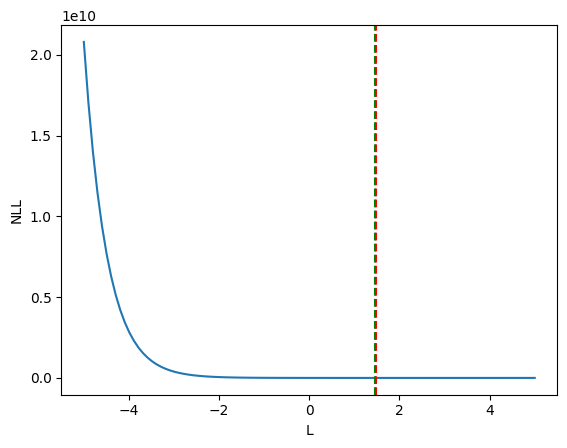

In [133]:
plt.plot(L_list, NLL_list)
plt.axvline(x=right_L.item(), color='r', linestyle='--')
plt.axvline(x=L_list[min_idx].item(), color='g', linestyle='--')
plt.xlabel("L")
plt.ylabel("NLL")
plt.show()


In [134]:
n_features = 1
n_dimensions = 4
right_L = t.randn(n_features, n_dimensions * (n_dimensions + 1) // 2)

gaussian = MultidimensionalGaussian(n_features, n_dimensions, right_L)
L_learned = t.randn(n_features, n_dimensions * (n_dimensions + 1) // 2, requires_grad=True)
optimizer = optim.Adam([L_learned], lr=0.01)
batch_size = 100000
n_batches = 2000
loss_learned = []
loss_correct = []
for i in range(n_batches):
    optimizer.zero_grad()
    acts, outputs = gaussian.sample(batch_size)
    loss = NLL(L_learned, acts, outputs)
    loss.backward()
    optimizer.step()
    loss_learned.append(loss.item())
    loss_correct.append(NLL(right_L, acts, outputs).item())
    if i % 100 == 0:
        print(f"Batch {i}, loss: {loss.item()}")

Batch 0, loss: 33582908.0
Batch 100, loss: 3693179.0
Batch 200, loss: 1913710.5
Batch 300, loss: 1276362.75
Batch 400, loss: 969296.625
Batch 500, loss: 789371.5
Batch 600, loss: 666740.5
Batch 700, loss: 575926.6875
Batch 800, loss: 513639.46875
Batch 900, loss: 464819.75
Batch 1000, loss: 426144.4375
Batch 1100, loss: 397152.65625
Batch 1200, loss: 374613.875
Batch 1300, loss: 353388.375


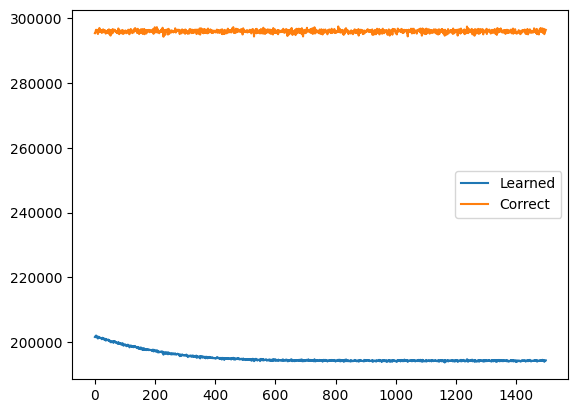

In [81]:
n_start_plot = 500
plt.plot(loss_learned[n_start_plot:], label="Learned")
plt.plot(loss_correct[n_start_plot:], label="Correct")
#plt.ylim(4600, 10000)
plt.legend()
#plt.yscale('log')
plt.show()

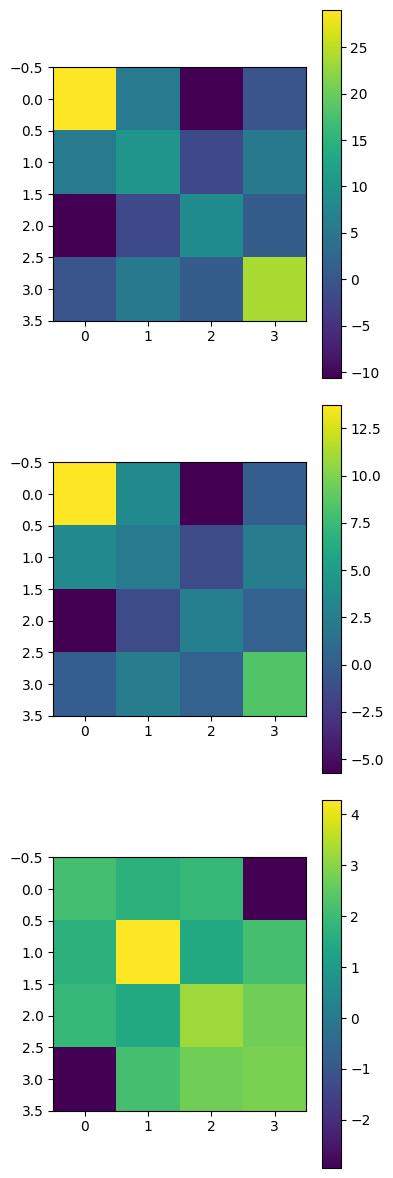

In [91]:
A_learned = cholesky_parametrization(L_learned)
A_correct = cholesky_parametrization(right_L)
fig, axs = plt.subplots(3, A_learned.shape[0], figsize=(4*A_learned.shape[0], 12))
n_matrices = A_learned.shape[0]
if n_matrices == 1:
    axs = axs[:, None]
for i in range(A_learned.shape[0]):
    im0 = axs[0, i].imshow(A_learned[i].detach().numpy())
    fig.colorbar(im0, ax=axs[0, i])
    
    im1 = axs[1, i].imshow(A_correct[i].detach().numpy())
    fig.colorbar(im1, ax=axs[1, i])
    
    im2 = axs[2, i].imshow((A_learned[i] / A_correct[i]).detach().numpy())
    fig.colorbar(im2, ax=axs[2, i])

plt.tight_layout()
plt.show()

In [84]:
A_learned

tensor([[[ 29.0420,   5.9365, -10.6540,  -0.2518],
         [  5.9365,  10.0602,  -1.8585,   5.3767],
         [-10.6540,  -1.8585,   8.6675,   1.1247],
         [ -0.2518,   5.3767,   1.1247,  23.9804]]], grad_fn=<AddBackward0>)

In [90]:
A_correct*np.sqrt(3)

tensor([[[23.8020,  6.0276, -9.9430,  0.1480],
         [ 6.0276,  4.0716, -2.2199,  4.3329],
         [-9.9430, -2.2199,  4.6689,  0.7152],
         [ 0.1480,  4.3329,  0.7152, 14.6411]]])